<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Exercise.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Exercise: Decision trees
© ExploreAI Academy

In this exercise, we will test our knowledge of the fundamental concepts of decision trees by implementing a decision tree regression model and analysing its performance metrics.

By the end of this exercise, you should be able to:
* Implement a decision tree regression model

# Initial data exploration

We will be using our agriculture dataset to explore the effect climate change has on crops in Maji Ndogo. As a refresher of our data, examine the data dictionary.

# Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Crop_type:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, and check that the database file is created correctly, otherwise the data import will fail.
 
[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)


In [3]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2024-03-22 14:31:09,551 - data_ingestion - INFO - Database engine created successfully.
2024-03-22 14:31:09,630 - data_ingestion - INFO - Query executed successfully.
2024-03-22 14:31:09,630 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-03-22 14:31:09,630 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2024-03-22 14:31:10,202 - data_ingestion - INFO - CSV file read successfully from the web.


Let's take a quick look at our dataset to ensure it imported correctly.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
import matplotlib.pyplot as plt

Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [5]:
# Validate the data
# !pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)



import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

Deleted sampled_field_df.csv


In [6]:
dataset.head()

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,0.085267,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,0.399684,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,0.358029,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,0.286687,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,0.043190,1.5,0.832614,wheat,0.555076


## Exercises

### Exercise 1 

To begin our exploration of the dataset, we will use a decision tree to explore how all of the variables affect our crop yields.

Given our dataset containing information on environmental factors and crop yields, how can we train a decision tree model to predict crop yields accurately?

Fit a decision tree regressor model to the entire dataset.

Use all predictor variables (excluding non-numeric columns) to predict `Standard_yield`. 

Set the `max_depth` to 4 and the `random_state` to 42 for reproducibility.

Considering the **MSE** and **R²** values, how effective is the decision tree in predicting crop yields using all of our variables?

In [45]:
#Your code here
non_numeric_cols = list(dataset.select_dtypes(exclude='number').columns)
X = dataset.drop(columns=['Standard_yield'] + non_numeric_cols)
y = dataset['Standard_yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dt = DecisionTreeRegressor(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.008029115409437999
0.3974590163099897


### Exercise 2

While the model shows some predictive capability with a moderate R² value, there is still room for improvement, particularly in reducing the MSE and potentially increasing the explanatory power of the model. This can be achieved through further feature selection, hyperparameter tuning, or exploring alternative modeling techniques.

Lets start with feature selection. What environmental factors have the highest correlation with crop yields, and how can we use this information to improve the predictive performance of our model?

Conduct feature selection using a **correlation matrix** to select relevant features for predicting `Standard_yield`.

Visualise the matrix to better identify the features with the highest correlation with `Standard_yield`.

Regarding features to retain and eliminate, what do the results suggest? Have you thought about the independent features that might be correlated? 


<Axes: >

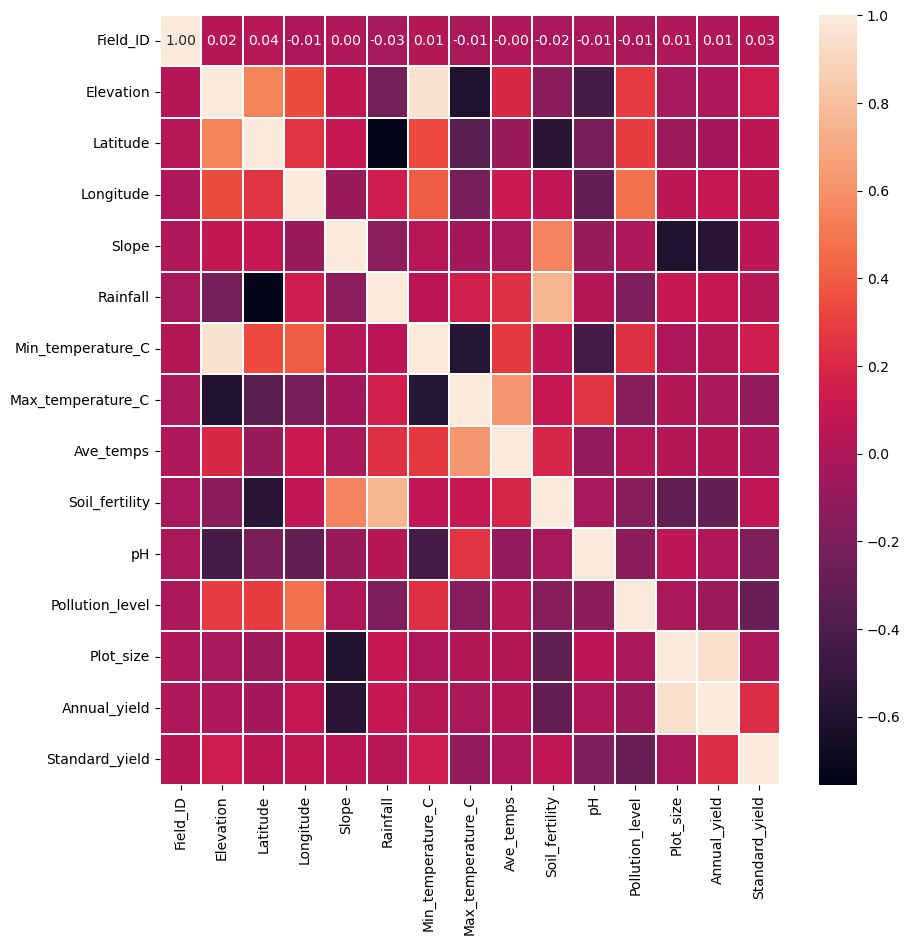

In [46]:
#Your code here
numeric = dataset.select_dtypes(include='number')
numeric.corr()['Standard_yield'].sort_values(ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(numeric.corr(), annot=True, linewidths=0.2, fmt='.2f')

### Exercise 3
Now that we know which features could work best for our model, let's run our model again on a reduced dataset.

Reduce the dataset to only include `Pollution_level`, `Min_temperature_C`, `Longitude`, and `pH`.

Refit the decision tree regressor model using the reduced dataset and evaluate the model's performance on the test set to determine if there's an improvement in MSE and R² values.

Does reducing the dataset lead to an improvement in the predictive performance of our model?

Run the model on different combinations of the reduced dataset. Is there a combination of variables or a single variable that improves the MSE and R²?

In [47]:
#Your code here
X = dataset[['Pollution_level', 'Min_temperature_C', 'Longitude', 'pH']]
y = dataset['Standard_yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.008975851753736153
0.3264116569062441


### Exercise 4
Now that we have attempted feature engineering, let's move on to parameter tuning. What is the optimal depth for the decision tree model that maximizes predictive performance while avoiding overfitting?

Use a loop to fit decision tree models with depths ranging from 1 to 10 and assess the MSE and R² scores for each depth.
Analyse the results to identify the depth that maximizes R² while avoiding significant increases in MSE, indicating optimal model complexity.

In [48]:
#Your code here

for depth in range(1, 11):
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_test)
    print('Depth = ' + str(depth))
    print(mean_squared_error(y_test, y_pred))
    print(r2_score(y_test, y_pred))
    print()

Depth = 1
0.011737767135569468
0.11914508690748249

Depth = 2
0.00990438387602821
0.25673042431417337

Depth = 3
0.009118350398801085
0.31571791676259253

Depth = 4
0.008975851753736153
0.3264116569062441

Depth = 5
0.008948027292211625
0.3284997298212162

Depth = 6
0.008939215171039544
0.3291610310840154

Depth = 7
0.00893602597906899
0.32940036241369774

Depth = 8
0.008996853759614145
0.32483557179152345

Depth = 9
0.009722706766464749
0.27036429289472064

Depth = 10
0.010107657838130987
0.24147583064623301



## Solutions

### Exercise 1

In [49]:

# Drop non-numeric columns
non_numeric_columns = ['Location', 'Soil_type', 'Crop_type']
#split data into dependant and independant variables
X = dataset.drop(columns=['Standard_yield'] + non_numeric_columns)
y = dataset['Standard_yield']
    
# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
# Train the model
model = DecisionTreeRegressor(max_depth=4, random_state=42).fit(X_train, y_train)
predictions = model.predict(X_test)
    
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
    
result = {'mse': mse, 'r2': r2, 'model_depth': model.get_depth()}
result



{'mse': 0.007852911867489898, 'r2': 0.3895258341057801, 'model_depth': 4}

While the model shows some predictive capability with a moderate R² value, there is still room for improvement, particularly in reducing the MSE and potentially increasing the explanatory power of the model.

### Exercise 2

Correlation with Standard_yield:
 Standard_yield       1.000000
Annual_yield         0.220812
Min_temperature_C    0.144233
Elevation            0.129248
Longitude            0.085343
Soil_fertility       0.070205
Latitude             0.061724
Slope                0.056991
Rainfall             0.039217
Field_ID             0.030802
Ave_temps            0.006786
Plot_size           -0.017014
Max_temperature_C   -0.111649
pH                  -0.196613
Pollution_level     -0.285761
Name: Standard_yield, dtype: float64


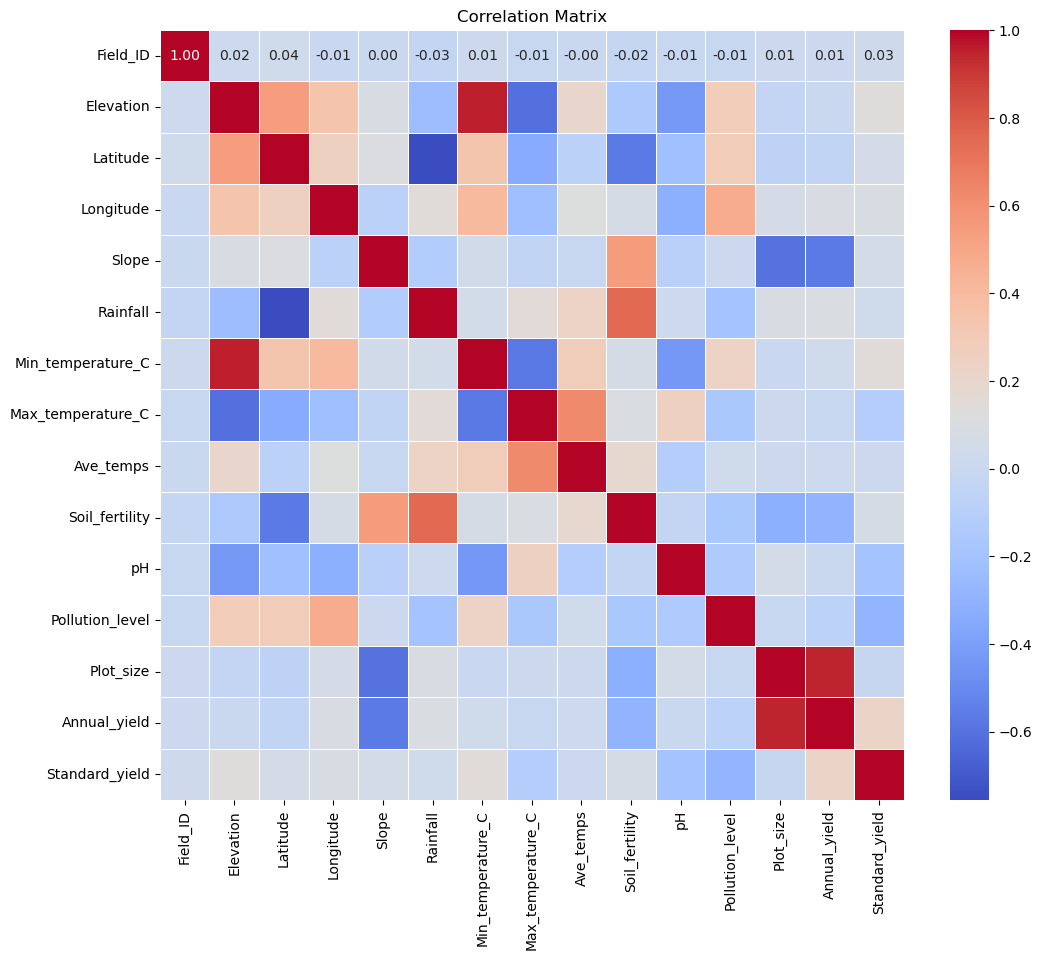

In [50]:


# 1. Correlation Analysis
non_numeric_dataset = dataset.drop(columns = ['Location', 'Soil_type', 'Crop_type'])
correlation_matrix = non_numeric_dataset.corr()
print("Correlation with Standard_yield:\n", correlation_matrix['Standard_yield'].sort_values(ascending=False))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


Based on the resulting correlation matrix, we would retain the variables with comparatively higher positive or negative absolute correlation coefficients, such as Annual_yield, Min_temperature_C, pH, Pollution_level, and Soil_fertility, and exclude the ones with lower correlation coefficients. It is however important to also use some knowledge we have in how the Standard_yield variable was created - we used Annual_yield as in input, and as such, including it as a predictive variable should be carefully thought about. Let's see what happens if we don't include it for now.  

This will help us retain the most influential features for predicting crop yields while reducing the complexity of the model.

### Exercise 3

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the features to keep based on correlation analysis
features_to_keep = ['Pollution_level','Min_temperature_C','Longitude','pH']

# Prepare the dataset with only the selected features
X = dataset[features_to_keep]
y = dataset['Standard_yield']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the decision tree model
model = DecisionTreeRegressor(max_depth=4, random_state=42).fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Store the results
result = {'mse': mse, 'r2': r2, 'model_depth': model.get_depth()}
result



{'mse': 0.008844274351502885, 'r2': 0.3124587288410299, 'model_depth': 4}


The model's performance has not improved. The MSE has increased and the R-squared value has decreased. This indicates that using only the selected features has led to a worse predictive performance compared to the previous model. This illustrates the cost of simplified models - we're losing predictive ability whilst gaining ease of interpretation. It's also worth remembering that the R-squared value generally increases as more variable are added - which shouldn't tempt us to do so without good reason!

### Exercise 4

In [52]:
# Define a range of depths to try
depths_to_try = range(1, 11)

# Initialise empty lists to store results
mse_scores = []
r2_scores = []

# Iterate over depths and fit models
for depth in depths_to_try:
    # Train the model
    model = DecisionTreeRegressor(max_depth=depth, random_state=42).fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # Append scores to lists
    mse_scores.append(mse)
    r2_scores.append(r2)

# Print the results
for depth, mse, r2 in zip(depths_to_try, mse_scores, r2_scores):
    print(f"Depth: {depth}, MSE: {mse}, R2: {r2}")


Depth: 1, MSE: 0.011346751164118245, R2: 0.11791975137262489
Depth: 2, MSE: 0.009765370470906087, R2: 0.24085403052155063
Depth: 3, MSE: 0.00902979208907587, R2: 0.2980368445751046
Depth: 4, MSE: 0.008844274351502885, R2: 0.3124587288410299
Depth: 5, MSE: 0.00866221343822956, R2: 0.32661188451728207
Depth: 6, MSE: 0.008533708422990784, R2: 0.33660168108126565
Depth: 7, MSE: 0.00893807158150368, R2: 0.3051670659885565
Depth: 8, MSE: 0.009702572127229836, R2: 0.24573588417306147
Depth: 9, MSE: 0.009847201997907543, R2: 0.2344925643504001
Depth: 10, MSE: 0.010035282722640166, R2: 0.21987143711895063


As the depth of the decision tree increases, the MSE generally decreases initially until reaching a minimum at depth 6. Beyond that, the MSE starts to increase again.

The R-squared values also show a similar trend to MSE, initially increasing until depth 6 is reached, and then slightly decreasing afterward.

Depth 6 seems to provide the best balance between model complexity and performance, as it has the lowest MSE among depths 1 to 5 and a relatively high R2 value compared to other depths.

Beyond depth 6, increasing the depth of the decision tree leads to overfitting, as indicated by the increasing MSE and decreasing R-squared values. This means the model starts capturing noise in the data rather than true patterns, resulting in poorer performance on unseen data.

As a final piece of testing (see it as a reward), select only the cassava crops and fit a decision tree to it. Tip: add in the Rainfall variable. The R-squared value is significantly higher than we had for our model. This suggests that we might need to break down the model into decision trees for each crop, or use dummy variables when creating it. Sometimes it's useful approaching the same data from different angles, as a fitted model can probably always be improved! 


#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>